In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from itertools import chain
import sklearn
from sklearn.preprocessing import LabelBinarizer
import sklearn_crfsuite as crfsuite
from sklearn_crfsuite import metrics
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW 
import numpy as np
import seqeval
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.metrics import classification_report as class_rep

from keras.preprocessing.sequence import pad_sequences

torch.__version__

MAX_LEN = 60
bs = 30
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /user/HS400/hb01440/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
import tensorflow as tf

In [68]:
print(tf.__version__)

2.16.1


In [3]:
def convert_to_list(data_list):
    df = pd.DataFrame(data_list)
    new_list = df.values.flatten()
    new_list = [tag for tag in new_list if tag is not None]
    return new_list

def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels
    LSTMLSTMLSTMLSTMLSTMLSTMLSTMLSTM
def get_words_tags(df_dataset, set):
    words = []
    words = pd.Series(convert_to_list(df_dataset[set][:]['tokens'])).unique().tolist()
    words.append("ENDPAD")
    num_words = len(words)
    
    tags = pd.Series(convert_to_list(df_dataset[set][:]['ner_tags'])).unique().tolist()

    return words, tags, num_words

def get_sentence_tuples(df_dataset):
    sentences = []
    for tokens, ner_tags in zip(df_dataset['tokens'], df_dataset['ner_tags']):
        sentences.append(list(zip(tokens, ner_tags)))
    return sentences

def padding_data(word2idx, tag2idx, sentences, num_words):
    max_len = 50
    
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
    
    y = [[tag2idx[w[1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["B-O"])

    return X, y

def word2features(sent, i):
    word = sent[i][0]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
    ]
    if i > 0:
        word1 = sent[i-1][0]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
        ])
    else:
        features.append('BOS')

    if i > 1: 
        word2 = sent[i-2][0]
        features.extend([
            '-2:word.lower=' + word2.lower(),
            '-2:word.istitle=%s' % word2.istitle(),
            '-2:word.isupper=%s' % word2.isupper(),
        ])        

        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
        ])
    else:
        features.append('EOS')

    if i < len(sent)-2:
        word2 = sent[i+2][0]
        features.extend([
            '+2:word.lower=' + word2.lower(),
            '+2:word.istitle=%s' % word2.istitle(),
            '+2:word.isupper=%s' % word2.isupper(),
        ])

        
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

def flat_to_list_of_lists(flat_list, chunk_size):
    return [flat_list[i:i+chunk_size] for i in range(0, len(flat_list), chunk_size)]

from torch.nn import CrossEntropyLoss, MSELoss

def choose_loss_function(task):
    if task == "classification":
        return CrossEntropyLoss()
    elif task == "regression":
        return MSELoss()
    else:
        raise ValueError("Invalid task specified. Supported tasks: 'classification', 'regression'")


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Quadro P4000'

In [5]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

data = dataset['train']
data_test = dataset['test']
data_val = dataset['validation']

df = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])

sentences_data_train = get_sentence_tuples(df)
sentences_data_test = get_sentence_tuples(df_test)
sentences_data_val = get_sentence_tuples(df_val)

sentences_train = [[word[0] for word in sentence] for sentence in sentences_data_train]
sentences_val = [[word[0] for word in sentence] for sentence in sentences_data_val]
sentences_test = [[word[0] for word in sentence] for sentence in sentences_data_test]

labels_train = [[s[1] for s in sentence] for sentence in sentences_data_train]
labels_val = [[s[1] for s in sentence] for sentence in sentences_data_val]
labels_test = [[s[1] for s in sentence] for sentence in sentences_data_test]

In [6]:
tokens_flat = [token for sublist in df["ner_tags"].values for token in sublist]

tag_values = list(set(tokens_flat))
tag_values.append("PAD")


tag2idx = {t: i for i, t in enumerate(tag_values)}

In [7]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', do_lower_case=False)

In [8]:
tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

tokenized_texts_and_labels_val = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_val, labels_val)
]

tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_val = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_val]
labels_val = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_val]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_val = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_val],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_val = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_val],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_val = [[float(i != 0.0) for i in ii] for ii in input_ids_val]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]


In [9]:
train_inputs = torch.tensor(input_ids_train)
val_inputs = torch.tensor(input_ids_val)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
val_tags = torch.tensor(tags_val)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
val_masks = torch.tensor(attention_masks_val)
test_masks = torch.tensor(attention_masks_test)


In [10]:
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

val_data = TensorDataset(val_inputs, val_masks, val_tags)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [11]:
model = BertForTokenClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.cuda();

In [13]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


/user/HS400/hb01440/.local/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
from transformers import get_linear_schedule_with_warmup

epochs = 20
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [15]:
import os
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [16]:
%%time 

loss_values, development_loss_values = [], []

for _ in range(epochs):
    
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    loss_values.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(val_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Development Accuracy: {}".format(accuracy_score(pred_tags, dev_tags)))
    
    print("Development classification report:\n{}".format(class_rep(dev_tags, pred_tags)))

print("Saving model to %s" % output_dir)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Average train loss: 0.6380859480963813
Development loss: 0.26746008098125457
Development Accuracy: 0.8885763400531334
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.70      0.85      0.77       437
        B-LF       0.62      0.49      0.55       342
         B-O       0.94      0.94      0.94      5067
        I-LF       0.78      0.68      0.73       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.89      6399
   macro avg       0.61      0.59      0.60      6399
weighted avg       0.89      0.89      0.89      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.25527603924274445
Development loss: 0.2512294501066208
Development Accuracy: 0.8982653539615565
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.79      0.83      0.81       437
        B-LF       0.61      0.61      0.61       342
         B-O       0.96      0.93      0.94      5067
        I-LF       0.70      0.84      0.76       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.90      6399
   macro avg       0.61      0.64      0.62      6399
weighted avg       0.90      0.90      0.90      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.1839345068567329
Development loss: 0.24342210590839386
Development Accuracy: 0.9112361306454133
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.76      0.88      0.82       437
        B-LF       0.74      0.58      0.65       342
         B-O       0.95      0.95      0.95      5067
        I-LF       0.76      0.83      0.80       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.91      6399
   macro avg       0.64      0.65      0.64      6399
weighted avg       0.91      0.91      0.91      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.13629652911590207
Development loss: 0.2354726731777191
Development Accuracy: 0.9149867166744804
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.87      0.78      0.82       437
        B-LF       0.68      0.61      0.65       342
         B-O       0.95      0.95      0.95      5067
        I-LF       0.77      0.86      0.81       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.91      6399
   macro avg       0.65      0.64      0.65      6399
weighted avg       0.91      0.91      0.91      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.09893324329621261
Development loss: 0.24191486835479736
Development Accuracy: 0.9170182841068917
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.82      0.84      0.83       437
        B-LF       0.69      0.62      0.66       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.76      0.88      0.82       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.92      6399
   macro avg       0.65      0.66      0.65      6399
weighted avg       0.92      0.92      0.92      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.0734260215734442
Development loss: 0.2867650866508484
Development Accuracy: 0.9195186747929364
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.82      0.85      0.84       437
        B-LF       0.70      0.65      0.68       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.79      0.84      0.81       553

    accuracy                           0.92      6399
   macro avg       0.82      0.82      0.82      6399
weighted avg       0.92      0.92      0.92      6399

Average train loss: 0.05187456666802367
Development loss: 0.2916788518428802
Development Accuracy: 0.9142053445850914
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.77      0.87      0.82       437
        B-LF       0.69      0.62      0.65       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.80      0.81      0.80

/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.04097185444293751
Development loss: 0.3226750373840332
Development Accuracy: 0.9168620096890139
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.85      0.84      0.84       437
        B-LF       0.67      0.65      0.66       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.76      0.87      0.81       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.92      6399
   macro avg       0.65      0.66      0.65      6399
weighted avg       0.92      0.92      0.92      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.02895588125102222
Development loss: 0.3132831811904907
Development Accuracy: 0.9173308329426473
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.79      0.85      0.82       437
        B-LF       0.66      0.66      0.66       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.82      0.82      0.82       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.92      6399
   macro avg       0.65      0.66      0.65      6399
weighted avg       0.92      0.92      0.92      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.02353842785426726
Development loss: 0.36783196926116946
Development Accuracy: 0.9204563213002032
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.85      0.85      0.85       437
        B-LF       0.70      0.65      0.67       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.78      0.85      0.82       553

    accuracy                           0.92      6399
   macro avg       0.82      0.83      0.82      6399
weighted avg       0.92      0.92      0.92      6399

Average train loss: 0.017442636269455154
Development loss: 0.36764477491378783
Development Accuracy: 0.9195186747929364
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.84      0.85      0.85       437
        B-LF       0.70      0.64      0.67       342
         B-O       0.96      0.95      0.96      5067
        I-LF       0.78      0.84      

/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.0124828793729345
Development loss: 0.39510796070098875
Development Accuracy: 0.9224878887326144
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.83      0.84      0.84       437
        B-LF       0.70      0.65      0.68       342
         B-O       0.96      0.96      0.96      5067
        I-LF       0.81      0.84      0.82       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.92      6399
   macro avg       0.66      0.66      0.66      6399
weighted avg       0.92      0.92      0.92      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.010351553763030097
Development loss: 0.39085112810134887
Development Accuracy: 0.9185810282856697
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.84      0.83      0.84       437
        B-LF       0.67      0.66      0.67       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.78      0.85      0.81       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.92      6399
   macro avg       0.65      0.66      0.65      6399
weighted avg       0.92      0.92      0.92      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.009719640294659056
Development loss: 0.39362558126449587
Development Accuracy: 0.92139396780747
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.85      0.83      0.84       437
        B-LF       0.70      0.65      0.67       342
         B-O       0.96      0.96      0.96      5067
        I-LF       0.79      0.85      0.82       553
         PAD       0.00      0.00      0.00         0

    accuracy                           0.92      6399
   macro avg       0.66      0.66      0.66      6399
weighted avg       0.92      0.92      0.92      6399



/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average train loss: 0.006525074193228243
Development loss: 0.41670777201652526
Development Accuracy: 0.9185810282856697
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.81      0.87      0.84       437
        B-LF       0.68      0.65      0.66       342
         B-O       0.96      0.95      0.95      5067
        I-LF       0.79      0.84      0.81       553

    accuracy                           0.92      6399
   macro avg       0.81      0.83      0.82      6399
weighted avg       0.92      0.92      0.92      6399

Average train loss: 0.006416388560966071
Development loss: 0.4240307152271271
Development Accuracy: 0.9154555399281138
Development classification report:
              precision    recall  f1-score   support

        B-AC       0.81      0.87      0.84       437
        B-LF       0.65      0.67      0.66       342
         B-O       0.96      0.94      0.95      5067
        I-LF       0.77      0.85      

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [17]:
import json
with open(os.path.join(output_dir, 'tag2idx.json'), 'w') as f:
    json.dump(tag2idx, f)

In [18]:
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

input_ids_list = []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)
    
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
test_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
print("Test Accuracy: {}".format(accuracy_score(pred_tags, test_tags),digits=4))
print("Test classification report: {}".format(class_rep(pred_tags, test_tags)))
print()

report_fbert_dict = class_rep(test_tags, pred_tags, output_dict=True)


Test Accuracy: 0.915150673517567
Test classification report:               precision    recall  f1-score   support

        B-AC       0.79      0.77      0.78       546
        B-LF       0.70      0.68      0.69       376
         B-O       0.95      0.96      0.95      5663
        I-LF       0.84      0.77      0.80       614
         PAD       0.00      0.00      0.00         2

    accuracy                           0.92      7201
   macro avg       0.65      0.64      0.65      7201
weighted avg       0.91      0.92      0.91      7201




/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01440/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/hb01

In [20]:
import pandas as pd
from tqdm import tqdm
import time

test_sentences = [
    "The internationalization (i18n) of our software will be a challenging endeavor.",
    "The environmental conservationists were discussing the impact of chlorofluorocarbons (CFCs).",
    "The telecommunications industry often relies on the Global Positioning System (GPS).",
    "The anthropomorphization in the AI-generated content is quite impressive.",
    "The new hyperconverged infrastructure (HCI) system is both efficient and scalable.",
    "The bioluminescence in the ocean was a topic of study for the marine biologists (MB).",
    "The geostationary operational environmental satellite (GOES) is crucial for weather monitoring.",
    "The thermoelectric power generation (TEG) technology is gaining traction.",
    "The hypertext transfer protocol secure (HTTPS) ensures secure communications over the internet.",
    "The archaeologists used ground-penetrating radar (GPR) to locate ancient structures.",
    "The mechanotransduction in cells is vital for understanding various biological processes.",
    "The neurolinguistics programming (NLP) techniques are used in therapy sessions.",
    "The intercontinental ballistic missile (ICBM) tests are a matter of global concern.",
    "The deoxyribonucleic acid (DNA) sequencing has revolutionized genetic research.",
    "The photosensitivity of the material was enhanced using specific treatments.",
    "The superconducting quantum interference device (SQUID) is used in sensitive magnetic measurements.",
    "The microelectromechanical systems (MEMS) are integral to modern technology.",
    "The artificial intelligence (AI) algorithms are improving rapidly.",
    "The photosynthesis process is crucial for plant life on Earth.",
    "The electroencephalogram (EEG) readings showed unusual brain activity.",
    "The psychopharmacological studies are essential for developing new medications.",
    "The ultrasonography (USG) was used to monitor the developing fetus.",
    "The semiconductor industry relies heavily on photolithography techniques.",
    "The antihypertensive medication helped in controlling high blood pressure.",
    "The electrocardiogram (ECG) results indicated a need for further testing.",
    "The climatologists are worried about the anthropogenic effects on climate change.",
    "The software development kit (SDK) includes comprehensive tools and documentation.",
    "The astronomers observed a new exoplanet using the Hubble Space Telescope (HST).",
    "The biocompatibility of the new implant material was tested extensively.",
    "The forensic anthropologists identified the remains using mitochondrial DNA (mtDNA).",
    "The photosynthetic efficiency of the new plant variety was remarkable.",
    "The cardiopulmonary resuscitation (CPR) training is essential for emergency responders.",
    "The electromagnetic interference (EMI) was causing issues with the equipment.",
    "The magnetohydrodynamics (MHD) principles are applied in nuclear fusion research.",
    "The organizational behavior (OB) study focused on employee motivation.",
    "The phytoremediation techniques are used to clean up contaminated soils.",
    "The paleoclimatology studies provide insights into ancient weather patterns.",
    "The nanotechnology applications in medicine are expanding rapidly.",
    "The comprehensive metabolic panel (CMP) is a common blood test.",
    "The electromagnetic spectrum (EMS) includes various types of radiation.",
    "The sociocultural anthropology explores the relationship between cultures and societies.",
    "The hyperbaric oxygen therapy (HBOT) is used to treat various conditions.",
    "The bioluminescent organisms in the deep sea create a mesmerizing display.",
    "The endocrinologists study the impact of hormones on human health.",
    "The computerized tomography (CT) scan revealed the extent of the injury.",
    "The aerodynamic properties of the new aircraft design were tested in a wind tunnel.",
    "The immunohistochemistry (IHC) is used to diagnose diseases in tissue samples.",
    "The bioluminescence was most noticeable in the plankton samples collected.",
    "The hematopoietic stem cells (HSCs) are crucial for blood formation.",
    "The electromechanical systems are integral to modern robotics.",
    "The thermodynamic stability of the compound was analyzed in the lab.",
    "The microprocessor performance has been significantly enhanced.",
    "The electrophysiology studies provided insights into heart function.",
    "The organizational development (OD) strategies were discussed in the meeting.",
    "The psychoeducational assessments help in identifying learning disabilities.",
    "The geostationary satellites provide constant monitoring of weather patterns.",
    "The ultramicroscopic details of the sample were revealed using electron microscopy.",
    "The biomechanical engineering field combines biology and mechanics.",
    "The hydroelectric power plants generate energy from flowing water.",
    "The psychophysiological responses were measured during the experiment.",
    "The gastroenterologists specialize in the digestive system.",
    "The thermoelectric materials convert heat into electricity.",
    "The archeological discoveries were presented at the international conference (IC).",
    "The electrophoresis technique is used to separate DNA fragments.",
    "The geophysicists study the physical properties of the Earth.",
    "The hyperthyroidism was treated with medication and lifestyle changes.",
    "The biopharmaceutical industry is growing rapidly.",
    "The thermoluminescence dating method is used in archeology.",
    "The spectrophotometer measures the intensity of light in a sample.",
    "The immunodeficiency was diagnosed based on the patient's history.",
    "The paramedics performed advanced life support (ALS) procedures.",
    "The microclimatology studies focus on small-scale weather patterns.",
    "The electrooculography (EOG) tracks eye movements.",
    "The interdisciplinary research team included experts from various fields.",
    "The pharmacokinetics of the new drug were studied in clinical trials.",
    "The petrochemical industry produces a wide range of products.",
    "The photovoltaic cells convert sunlight into electricity.",
    "The climatological data were analyzed to predict future weather trends.",
    "The geotechnical engineering principles are applied in construction.",
    "The macromolecular structure of the protein was determined using X-ray crystallography.",
    "The telecommunication networks rely on fiber optic technology.",
    "The psychotropic medications are used to treat mental health conditions.",
    "The paleoanthropology research provided insights into early human life.",
    "The electrochromic materials change color when an electric field is applied.",
    "The electrocardiography (ECG) technician monitored the patient's heart.",
    "The sociolinguistic study focused on language use in different communities.",
    "The hypersonic speeds were achieved by the new aircraft prototype.",
    "The electroencephalography (EEG) recorded the brain's electrical activity.",
    "The thermoplastic materials become pliable at certain temperatures.",
    "The microbiological analysis revealed the presence of harmful bacteria.",
    "The spectroscopic analysis was used to determine the chemical composition.",
    "The anthropomorphization in the robot's design made it more relatable.",
    "The orthopedic surgeons specialize in the musculoskeletal system.",
    "The telehealth services expanded access to medical care.",
    "The neurophysiology lab studied the nervous system functions.",
    "The hydrogeological studies were important for managing water resources.",
    "The aerodynamics of the new car design improved fuel efficiency.",
    "The hematological disorders were treated with specialized medications.",
    "The bacteriological tests confirmed the infection.",
    "The astrophysicists presented their findings on black holes at the symposium."
]




100%|████████████████████████████████████████| 100/100 [00:00<00:00, 234.03it/s]


In [93]:
exaggerated_test_sentences = test_sentences * 10

In [85]:
endpoint_url = 'http://127.0.0.1:5000/predict_json'

In [86]:
import requests
from tqdm import tqdm
import pandas as pd
import time
import concurrent.futures

def predict_sentence_json(sentence, endpoint_url):
    payload = {'sentence': sentence}
    response = requests.post(endpoint_url, json=payload)
    
    if response.status_code == 200:
        return response.json().get('predicted_tags', [])
    else:
        return f'Error: {response.status_code}'






In [87]:
results = []
for sentence in tqdm(test_sentences):
    start_time = time.time()
    predicted_tags = predict_sentence(sentence, endpoint_url)
    end_time = time.time()
    response_time = end_time - start_time
    results.append({'sentence': sentence, 'predicted_tags': predicted_tags, 'response_time': response_time})

df_results = pd.DataFrame(results)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.60it/s]


In [88]:
print(f'Mean response time: {df_results["response_time"].mean():.3f} seconds')
print(f'Median response time: {df_results["response_time"].median():.3f} seconds')
print(f'90th percentile response time: {df_results["response_time"].quantile(0.9):.3f} seconds')

Mean response time: 0.037 seconds
Median response time: 0.030 seconds
90th percentile response time: 0.036 seconds


In [89]:
def stress_test(num_requests, endpoint_url):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(predict_sentence, sentence, endpoint_url) for sentence in test_sentences[:num_requests]]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    return results

In [90]:
print(stress_test(8000, endpoint_url))

[[['The', 'B-O'], ['telecommunications', 'B-O'], ['industry', 'B-O'], ['often', 'B-O'], ['relies', 'B-O'], ['on', 'B-O'], ['the', 'B-O'], ['Global', 'B-LF'], ['Positioning', 'I-LF'], ['System', 'I-LF'], ['(', 'B-O'], ['GPS', 'B-AC'], [')', 'B-O'], ['.', 'B-O']], [['The', 'B-O'], ['environmental', 'B-O'], ['conservationists', 'B-O'], ['were', 'B-O'], ['discussing', 'B-O'], ['the', 'B-O'], ['impact', 'B-O'], ['of', 'B-O'], ['chlorofluorocarbons', 'B-LF'], ['(', 'B-O'], ['CFCs', 'B-AC'], [')', 'B-O'], ['.', 'B-O']], [['The', 'B-O'], ['internationalization', 'B-LF'], ['(', 'B-O'], ['i18n', 'B-AC'], [')', 'B-O'], ['of', 'B-O'], ['our', 'B-O'], ['software', 'B-O'], ['will', 'B-O'], ['be', 'B-O'], ['a', 'B-O'], ['challenging', 'B-O'], ['endeavor', 'B-O'], ['.', 'B-O']], [['The', 'B-O'], ['anthropomorphization', 'B-O'], ['in', 'B-O'], ['the', 'B-O'], ['AI', 'B-AC'], ['-', 'B-O'], ['generated', 'B-O'], ['content', 'B-O'], ['is', 'B-O'], ['quite', 'B-O'], ['impressive', 'B-O'], ['.', 'B-O']], [[

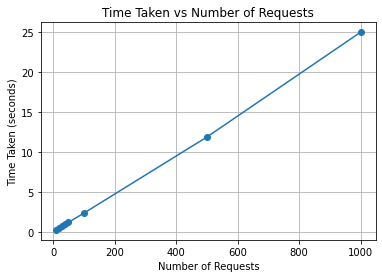

In [94]:

def stress_test(num_requests_list, endpoint_url):
    time_taken = []
    for num_requests in num_requests_list:
        start_time = time.time()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(predict_sentence, sentence, endpoint_url) for sentence in exaggerated_test_sentences[:num_requests]]
            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        end_time = time.time()
        time_taken.append(end_time - start_time)
    return results, time_taken

num_requests_list = [10, 20, 30, 40, 50, 100, 500, 1000]  # Varying number of requests
results, time_taken = stress_test(num_requests_list, endpoint_url)

plt.plot(num_requests_list, time_taken, marker='o')
plt.xlabel('Number of Requests')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Requests')
plt.grid(True)
plt.show()

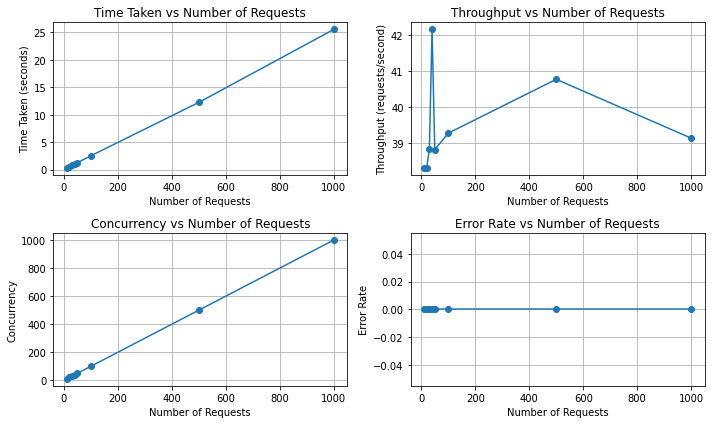

In [95]:
import time
import concurrent.futures
import matplotlib.pyplot as plt

def stress_test(num_requests_list, endpoint_url):
    time_taken = []
    throughput = []
    concurrency = []
    error_rates = []

    for num_requests in num_requests_list:
        start_time = time.time()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(predict_sentence, sentence, endpoint_url) for sentence in exaggerated_test_sentences[:num_requests]]
            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        end_time = time.time()
        time_taken.append(end_time - start_time)

        throughput.append(num_requests / (end_time - start_time))

        concurrency.append(len(futures))

        error_count = sum(1 for result in results if isinstance(result, str) and result.startswith('Error'))
        error_rates.append(error_count / num_requests)

    return time_taken, throughput, concurrency, error_rates

num_requests_list = [10, 20, 30, 40, 50, 100, 500, 1000]  
time_taken, throughput, concurrency, error_rates = stress_test(num_requests_list, endpoint_url)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(num_requests_list, time_taken, marker='o')
plt.xlabel('Number of Requests')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Requests')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(num_requests_list, throughput, marker='o')
plt.xlabel('Number of Requests')
plt.ylabel('Throughput (requests/second)')
plt.title('Throughput vs Number of Requests')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(num_requests_list, concurrency, marker='o')
plt.xlabel('Number of Requests')
plt.ylabel('Concurrency')
plt.title('Concurrency vs Number of Requests')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(num_requests_list, error_rates, marker='o')
plt.xlabel('Number of Requests')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Number of Requests')
plt.grid(True)

plt.tight_layout()
plt.show()


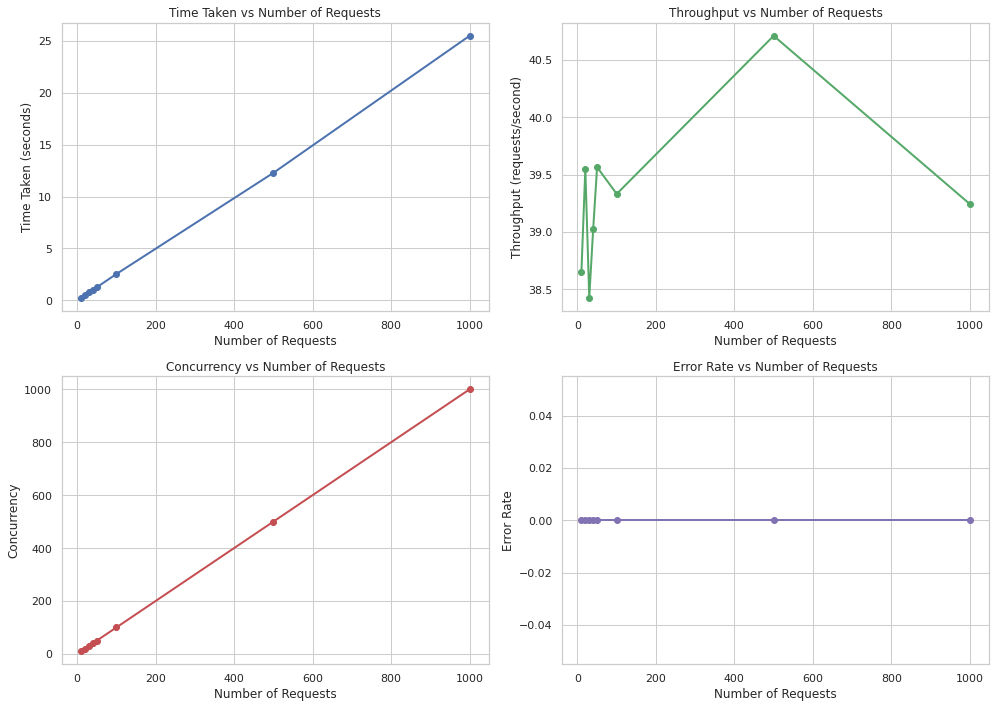

In [96]:
import time
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns

def stress_test(num_requests_list, endpoint_url):
    time_taken = []
    throughput = []
    concurrency = []
    error_rates = []

    for num_requests in num_requests_list:
        start_time = time.time()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(predict_sentence, sentence, endpoint_url) for sentence in exaggerated_test_sentences[:num_requests]]
            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        end_time = time.time()
        time_taken.append(end_time - start_time)

        throughput.append(num_requests / (end_time - start_time))

        concurrency.append(len(futures))

        error_count = sum(1 for result in results if isinstance(result, str) and result.startswith('Error'))
        error_rates.append(error_count / num_requests)

    return time_taken, throughput, concurrency, error_rates

num_requests_list = [10, 20, 30, 40, 50, 100, 500, 1000]  
time_taken, throughput, concurrency, error_rates = stress_test(num_requests_list, endpoint_url)

sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(num_requests_list, time_taken, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
axs[0, 0].set_xlabel('Number of Requests')
axs[0, 0].set_ylabel('Time Taken (seconds)')
axs[0, 0].set_title('Time Taken vs Number of Requests')
axs[0, 0].grid(True)

axs[0, 1].plot(num_requests_list, throughput, marker='o', color='g', linestyle='-', linewidth=2, markersize=6)
axs[0, 1].set_xlabel('Number of Requests')
axs[0, 1].set_ylabel('Throughput (requests/second)')
axs[0, 1].set_title('Throughput vs Number of Requests')
axs[0, 1].grid(True)

axs[1, 0].plot(num_requests_list, concurrency, marker='o', color='r', linestyle='-', linewidth=2, markersize=6)
axs[1, 0].set_xlabel('Number of Requests')
axs[1, 0].set_ylabel('Concurrency')
axs[1, 0].set_title('Concurrency vs Number of Requests')
axs[1, 0].grid(True)

axs[1, 1].plot(num_requests_list, error_rates, marker='o', color='m', linestyle='-', linewidth=2, markersize=6)
axs[1, 1].set_xlabel('Number of Requests')
axs[1, 1].set_ylabel('Error Rate')
axs[1, 1].set_title('Error Rate vs Number of Requests')
axs[1, 1].grid(True)

plt.tight_layout()

plt.show()
